# Linear Probes on nsarrazin/chessformer

Measure how accurately the model sees the board, by training linear probes on layer 14 activations.

## Setup

In [9]:
import chess
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from datasets import load_dataset
import torch 
import datasets
from functools import partial


# load the model
model = GPT2LMHeadModel.from_pretrained("nsarrazin/chessformer").to("cuda")

model.eval()

# load the dataset and get a 10k set of games for training and a 10k set of games for testing
dataset = load_dataset("nsarrazin/lichess-games-2023-02")

train_dataset = dataset["train"].shuffle(seed=42).select(range(10000)).to_pandas()
test_dataset = dataset["train"].shuffle(seed=42).select(range(10000, 20000)).to_pandas()

# load the tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("nsarrazin/chessformer")

Resolving data files:   0%|          | 0/106 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/106 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/106 [00:00<?, ?it/s]

## Activation extraction

We store the activation vector for each layer for each token in the game. Each vector is 768 elements long, for 12 layers.

In [10]:
# Function to get activations
def get_activations(model, input_ids, attention_mask):
    activations = []
    
    def hook_fn(module, input, output):
        activations.append(output[0].detach())

    # Register hooks for each transformer layer
    hooks = []
    for layer in model.transformer.h:
        hooks.append(layer.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return activations, outputs.hidden_states

n_layers = len(model.transformer.h)

def process_game(game):
    board = chess.Board()
    full_moves = game.moves

    model_inputs = tokenizer(' '.join(full_moves), return_tensors="pt").to("cuda")
    activations, _ = get_activations(model, model_inputs.input_ids, model_inputs.attention_mask)

    moves = []
    rows = []
    for j, move in enumerate(full_moves):
        board.push_uci(move)
        moves.append(move)

        row = {
            "fen": board.fen(),
            "moves": moves
        }

        for i in range(n_layers):
            row[f"layer{i}"] = activations[i][0, j, :].cpu().numpy()

        rows.append(row)

    return rows


def activation_generator():
    for _, game in train_dataset.iterrows():
        rows = process_game(game)
        for row in rows:
            yield row

# activation_generator()
ds = datasets.Dataset.from_generator(activation_generator)


Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/93 [00:00<?, ?it/s]

## Linear Probes

In [11]:
squares = [
    chess.square(j,i) for i in range(8) for j in range(8)
]


def plot_confidence(vector):
    import matplotlib.pyplot as plt
    import numpy as np

    confidence_matrix = np.reshape(vector, (8, 8)).T[::-1]
    
    plt.imshow(confidence_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()

    # set xtick labels as letters
    plt.xticks(range(8), ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
    plt.yticks(range(8), ['8', '7', '6', '5', '4', '3', '2', '1'])

    plt.show()

In [12]:
def validate_piece_on_board(fen: str, piece: chess.PieceType, color: chess.Color):
    board = chess.Board(fen)
    # return a 64 long vector with 1s for squares that match the piece and color
    return [1 if board.piece_at(square) and board.piece_at(square).piece_type == piece and board.piece_at(square).color == color else 0 for square in squares]


def validate_is_none(fen: str):
    board = chess.Board(fen)
    return [1 if board.piece_at(square) is None else 0 for square in squares]


pieces = [
    (None, None),
    (chess.PAWN, chess.WHITE),
    (chess.PAWN, chess.BLACK),
    (chess.KNIGHT, chess.WHITE),
    (chess.KNIGHT, chess.BLACK),
    (chess.BISHOP, chess.WHITE),
    (chess.BISHOP, chess.BLACK),
    (chess.ROOK, chess.WHITE),
    (chess.ROOK, chess.BLACK),
    (chess.QUEEN, chess.WHITE),
    (chess.QUEEN, chess.BLACK),
    (chess.KING, chess.WHITE),
    (chess.KING, chess.BLACK),
]

validation_functions = [
    validate_is_none,
    *[partial(validate_piece_on_board, piece=piece[0], color=piece[1]) for piece in pieces[1:]]
]

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm  # Import tqdm for notebook progress bar



In [14]:
# create a linear probe for each probe function

n_layer = 14

# generate a 64 length vector for each probe and stack them
def map_inputs(row):
    targets = torch.stack([torch.tensor(func(row["fen"])) for func in validation_functions], dim=1)
    input = torch.tensor(row[f"layer{n_layer}"])
    return {"input": input, "target": targets}

train_data = ds.map(map_inputs, remove_columns=["fen", "moves", "layer0", "layer1", "layer2", "layer3", "layer4", "layer5", "layer6", "layer7", "layer8", "layer9", "layer10", "layer11"]).with_format("torch")


Map:   0%|          | 0/650531 [00:00<?, ? examples/s]

In [15]:
from transformers import get_cosine_schedule_with_warmup
import torch.optim as optim

class LinearProbe(nn.Module):
    def __init__(self, input_dim=1024, output_dim=13, n_probes=64):
        super(LinearProbe, self).__init__()
        self.probes = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(n_probes)])

    def forward(self, x):
        out = torch.stack([probe(x) for probe in self.probes], dim=-2)
        return out


def train_probe(layer=14):
    probe = LinearProbe().to("cuda")

    batch_size = 32  # Define the batch size
    optimizer = optim.Adam(probe.parameters())
    loss_function = nn.CrossEntropyLoss()
    # load
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    n_steps = len(train_data) // batch_size

    EPOCHS = 1

    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=n_steps*5/100, num_training_steps=n_steps*EPOCHS)

    for epoch in range(EPOCHS):
        epoch_progress = tqdm(train_dataloader, leave=False, desc=f"Epoch {epoch+1}")
        for batch in epoch_progress:
            optimizer.zero_grad()
            
            input_data = batch["input"].to("cuda").float()
            target_data = batch["target"].to("cuda").float()  # Convert target to float
            
            # Forward pass
            output = probe(input_data)

            # go from [batch_size, 64, 13] to [batch_size * 64, 13]
            output = output.view(-1, output.size(-1))
            target_data = target_data.view(-1, target_data.size(-1))

            loss = loss_function(output, target_data)
            loss.backward()
            try:
                optimizer.step()
                scheduler.step()  # Step the scheduler
            except:
                break
            
            # Update tqdm with current loss and learning rate
            epoch_progress.set_postfix({
                "loss": f"{loss.item():.4f}",
                "lr": f"{scheduler.get_last_lr()[0]:.6f}"
            })
    
    return probe


import os

probes_path = "../model/probes.pth"
if os.path.exists(probes_path):
    probes = torch.load(probes_path)
else:
    probes = [None] * 18
    for layer in range(18):
        probe = train_probe(layer)
        probes[layer] = probe
    torch.save(probes, probes_path)
    probe = None



/tmp/ipykernel_209659/3811416929.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  probes = torch.load(probes_path)


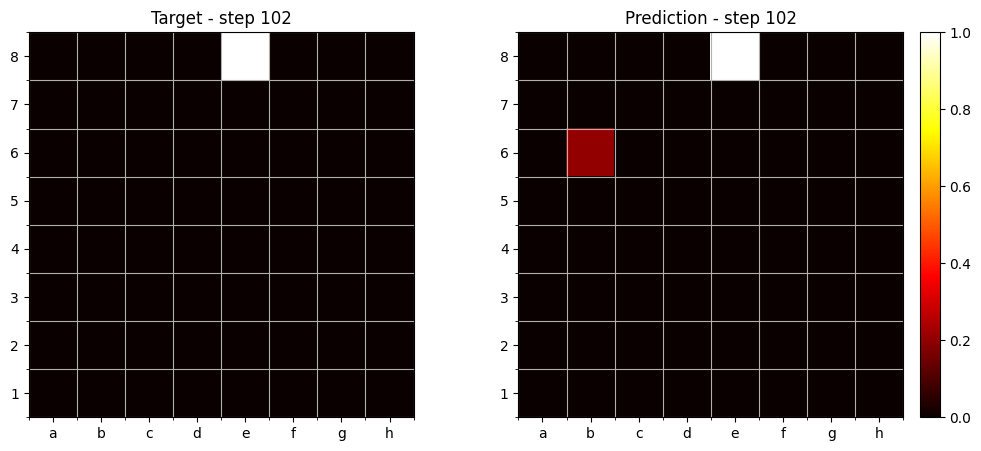

In [35]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import numpy as np

def plot_result(n_example, n_piece):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    example = train_data[n_example]

    target = example["target"]
    prediction = probes[17](example["input"].to("cuda"))
    prediction = torch.softmax(prediction, dim=-1)

    # Remove the indexing on n_piece from prediction
    ax1.set_title(f"Target - step {n_example}")
    ax2.set_title(f"Prediction - step {n_example}")
    
    # Rotate 90 degrees CCW and add chess board labels
    target_data = target.cpu().detach().numpy()[:, n_piece].reshape((8, 8))
    pred_data = prediction.cpu().detach().numpy()[:, n_piece].reshape((8, 8))
    
    ax1.imshow(np.flipud(target_data), cmap="hot", interpolation="nearest", vmin=0, vmax=1)
    im2 = ax2.imshow(np.flipud(pred_data), cmap="hot", interpolation="nearest", vmin=0, vmax=1)

    # Add chess board labels
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    ranks = ['1', '2', '3', '4', '5', '6', '7', '8']
    
    for ax in [ax1, ax2]:
        ax.set_xticks(np.arange(-0.5, 8.5, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 8.5, 1), minor=True)
        ax.set_xticks(range(8))
        ax.set_yticks(range(8))
        ax.set_xticklabels(files)
        ax.set_yticklabels(ranks[::-1])  # Reverse the rank labels
        ax.grid(True, which='minor')
        ax.grid(False, which='major')

    # Add colorbars for both plots
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    plt.show()

plot_result(102, 12)

In [21]:
# Create interactive sliders
interact(
    plot_result,
    n_example=IntSlider(min=0, max=150, step=1, value=102, description='Example'),
    n_piece=IntSlider(min=0, max=len(pieces)-1, step=1, value=12, description='Piece Type')
)

interactive(children=(IntSlider(value=102, description='Example', max=150), IntSlider(value=12, description='P…

<function __main__.plot_result(n_example, n_piece)>

In [36]:
import chess.svg
from IPython.display import display, HTML
from ipywidgets import interact, IntSlider

def plot_boards(n):
    example =train_data[n]["target"]
    input = train_data[n]["input"]

    board_target = chess.Board()
    board_target.clear()
    for square in squares:
        piece, color = pieces[torch.argmax(example[square])]
        if piece is not None:
            board_target.set_piece_at(square, chess.Piece(piece, color))

    board_prediction = chess.Board()
    board_prediction.clear()
    prediction = torch.softmax(probes[17](input.to("cuda")), dim=-1)
    prediction = torch.argmax(prediction, dim=-1).cpu().detach().numpy()

    fills = []
    for square in squares:
        piece, color = pieces[prediction[square]]
        if piece is not None:
            board_prediction.set_piece_at(square, chess.Piece(piece, color))
            # if the piece is not the same, add a red circle on the target board
            if board_target.piece_at(square) != board_prediction.piece_at(square):
                fills.append(square)

    svg_target = chess.svg.board(board_target)
    svg_prediction = chess.svg.board(board_prediction, fill=dict.fromkeys(fills, "#cc0000cc"))
    display(HTML(f'<div style="display: flex; justify-content: space-around;">'
                f'<div style="width: 45%;"><h3 style="text-align: center; font-size: 1.5em;">Target Board</h3>{svg_target}</div>'
                f'<div style="width: 45%;"><h3 style="text-align: center; font-size: 1.5em;">Model Prediction</h3>{svg_prediction}</div>'
                f'</div>'))


# plot game board at half move 106
plot_boards(102)

In [23]:
interact(
    plot_boards,
    n=IntSlider(min=0, max=150, step=1, value=102, description='Example')
)

interactive(children=(IntSlider(value=102, description='Example', max=150), Output()), _dom_classes=('widget-i…

<function __main__.plot_boards(n)>